# Set configs


In [13]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


In [14]:
# load all the predefined functions
from plot_util import SurprisalLoader, SurprisalPlotter,load_file

# plot and save the results
neuron_colors = {
    0: "#1f77b4",  # blue for baseline
    1: "#4589b9",  # interpolated between 0 and 10
    2: "#6b9bbe",  # interpolated between 0 and 10
    5: "#a5bec6",  # interpolated between 0 and 10
    10: "#ff7f0e",  # orange (unchanged)
    25: "#c89f1d",  # interpolated between 10 and 50
    50: "#2ca02c",  # green (unchanged)
    500: "#9467bd",  # purple (unchanged)
}

In [3]:
ROOT = Path("/Users/jliu/workspace/RAG/")
fig_path = ROOT / "fig"
surprisal_path = ROOT / "results" / "surprisal" 
KL_path = ROOT / "results" / "token_freq"
geometry_path = ROOT / "results" / "directions" /  "geometry" / "EleutherAI"
freq_path = ROOT / "datasets/freq/EleutherAI/pythia-410m"

## Surprisal dynamics

In [4]:
# load file
stat_path = surprisal_path / "stat_all.csv"
resume = False
if stat_path.is_file() and resume:
    stat_frame = pd.read_csv(stat_path)
    print(f"Load from {stat_path}")
else:
    analyzer = SurprisalLoader(surprisal_path, effects=["boost", "suppress"])
    # Process all files and get statistics
    stats = analyzer.get_stat_all()


Stat file has been saved to /Users/jliu/workspace/RAG/results/surprisal/stat_all.csv


In [83]:
ylim_dict = {
    "merged": {"70m": [11.5, 15.5], "410m": [12.5, 14]},
    "longtail_words": {"70m": [13, 17], "410m": [13, 15.5]},
}

# plot and save the results
neuron_colors = {
    0: "#1f77b4",  # blue for baseline
    1: "#4589b9",  # interpolated between 0 and 10
    2: "#6b9bbe",  # interpolated between 0 and 10
    5: "#a5bec6",  # interpolated between 0 and 10
    10: "#ff7f0e",  # orange (unchanged)
    25: "#c89f1d",  # interpolated between 10 and 50
    50: "#2ca02c",  # green (unchanged)
    500: "#9467bd",  # purple (unchanged)
}

'''
surprisal_plotter = SurprisalPlotter(
    df=stats,
    output_dir=fig_path/"surprisal",
    neuron_colors=neuron_colors,
    ylim_dict=ylim_dict,
    neurons=[10, 50, 500],
    ablations=["random", "mean", "zero"],
)

surprisal_plotter.plot_all(eval_set="longtail_words")
'''

'\nsurprisal_plotter = SurprisalPlotter(\n    df=stats,\n    output_dir=fig_path/"surprisal",\n    neuron_colors=neuron_colors,\n    ylim_dict=ylim_dict,\n    neurons=[10, 50, 500],\n    ablations=["random", "mean", "zero"],\n)\n\nsurprisal_plotter.plot_all(eval_set="longtail_words")\n'

## KL distribution


## Geometric difference

In [84]:
import numpy as np

def convert_log(step: float) -> float:
    return np.log10(step + 1e-10)

def convert_log_step(file_path: Path,min_step=3.5):
    "convert steps into log steps."
    # Apply log conversion and filter
    data = pd.read_csv(file_path)
    # rename neuron types
    data["log_step"] = data["step"].apply(convert_log)
    data = data[data["log_step"]>min_step]
    return data

def load_subspace(data:pd.DataFrame,neuron_type_lst=None) -> pd.DataFrame:
    """Load and process a CSV file, filtering columns based on log scale."""
    # filter by the neuron type
    data['neuron'] = data['neuron'].replace('common', 'all')
    if neuron_type_lst:
        data = data[~data["neuron"].isin(neuron_type_lst)]
    # get the effective rate if required
    data["dim_prop"] = data["effective_dim"] / data["total_dim"]
    return data.groupby("neuron")

def load_orthogonality(data:pd.DataFrame,neuron_type_lst=None) -> pd.DataFrame:
    """Load and process a CSV file, filtering columns based on log scale."""
    # change neuron_type content
    data['pair'] = data['pair'].str.replace('sampled_common', 'random')
    data['pair'] = data['pair'].str.replace('common', 'all')
    # filter by the neuron type
    if neuron_type_lst:
        # Filter data to include any pair containing at least one item from neuron_type_lst
        data = data[~data["pair"].apply(lambda pair: any(item in pair for item in neuron_type_lst))]
    return data.groupby("pair")

def load_file(file_path:Path,metric:str,neuron_type_lst=None,min_step=3.5):
    """Wrapper func to laod different metrics."""
    # load data
    data = convert_log_step(file_path,min_step)
    if metric == "subspace":
        return load_subspace(data,neuron_type_lst=neuron_type_lst)
    if metric == "orthogonality":
        return load_orthogonality(data,neuron_type_lst=neuron_type_lst)
    return None




In [ ]:
def plot_geometry_step(metric,model_lst,neuron_type_lst,neuron_type_lst,ylim_dict,metric_dict):
    for model in model_lst:
        for neuron in neuron_lst:
            file_path = geometry_path/f"pythia-{model}-deduped"/metric/f"500_{neuron}.csv"
            data_grouped = load_file(file_path,metric=metric,neuron_type_lst=neuron_type_lst)
            for metric_val in metric_dict[metric]:
                for neuron_type, data_group in data_grouped:
                    plt.plot(data_group["log_step"],data_group[metric_val],label = neuron_type)
                    plt.title(f"{metric_val}: #neuron={neuron}, model={model}")
                plt.ylim(ylim_dict[metric_val])
                plt.legend()
                plt.show()

In [22]:
set(data["neuron"])

{'boost', 'common', 'sampled_common', 'suppress'}

In [88]:
# load file
model_lst = ["70m","410m"]
metric_lst = ["subspace","orthogonality"]
neuron_lst= [10,50,500]
metric_dict = {
    "subspace":["dim_prop","sv_decay_rate_2"],
    "orthogonality":["pct_near_orthogonal","mean_angle_degrees"]
    }
ylim_dict = {
    "dim_prop":[0,1.1],
    "sv_decay_rate_2":[1,3],
    "pct_near_orthogonal":[0,100],
    "mean_angle_degrees":[0,90]
    }


neuron_type_lst=["all"]
metric = "orthogonality"

def plot_geometry_step(output_path,metric,model_lst,neuron_lst,neuron_type_lst,ylim_dict,metric_dict):
    for model in model_lst:
        for neuron in neuron_lst:
            file_path = geometry_path/f"pythia-{model}-deduped"/metric/f"500_{neuron}.csv"
            data_grouped = load_file(file_path,metric=metric,neuron_type_lst=neuron_type_lst)
            for metric_val in metric_dict[metric]:
                for neuron_type, data_group in data_grouped:
                    plt.plot(data_group["log_step"],data_group[metric_val],label = neuron_type)
                    plt.title(f"{metric_val}: #neuron={neuron}, model={model}")
                plt.ylim(ylim_dict[metric_val])
                plt.legend()
                output_file = output_path / metric_val / f"{model}_{neuron}.png"
                output_file.parent()
                plt.savefig(output_file, dpi=300, bbox_inches="tight")



FileNotFoundError: [Errno 2] No such file or directory: '/Users/jliu/workspace/RAG/fig/orthogonality/pct_near_orthogonal/70m_10.png'

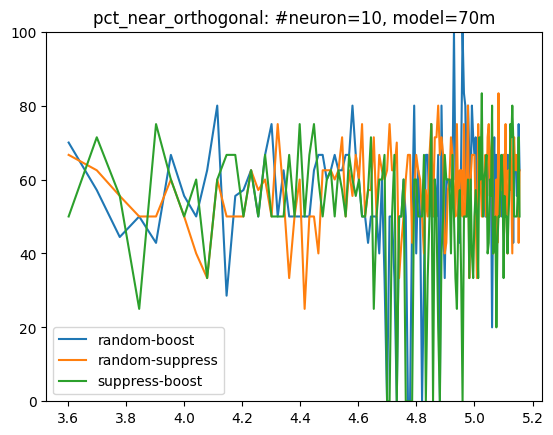

In [89]:
output_path = fig_path / metric
plot_geometry_step(output_path,metric,model_lst,neuron_lst,neuron_type_lst,ylim_dict,metric_dict)